# Step 1: Load and Explore the Dataset

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [35]:
import pandas as pd

# Load the dataset
file_path = "/content/final_preprocessed_data.csv"
df = pd.read_csv(file_path, parse_dates=["date"])

# Display the first few rows
df.head()


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,outlier_flag,...,lag_7,lag_30,rolling_std_7,lag_1,lag_2,lag_5,lag_10,lag_12,rolling_mean_7,dcoilwtico
0,16323662,2014-01-01,36,106716,3.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16324284,2014-01-01,36,1158720,28.0,0.0,GROCERY I,1040,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16352784,2014-01-02,24,106716,2.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,95.14
3,16353829,2014-01-02,24,1158720,20.0,0.0,GROCERY I,1040,0,0,...,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,95.14
4,16355696,2014-01-02,26,106716,8.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,95.14


In [36]:
df.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'family', 'class', 'perishable', 'outlier_flag', 'holiday_flag',
       'expanding_mean', 'lag_7', 'lag_30', 'rolling_std_7', 'lag_1', 'lag_2',
       'lag_5', 'lag_10', 'lag_12', 'rolling_mean_7', 'dcoilwtico'],
      dtype='object')

In [37]:
#Sort data by stores and give the top stores by unit sold
df.groupby('store_nbr')['unit_sales'].sum().sort_values(ascending=False).head(15)
print(df.groupby('store_nbr')['unit_sales'].sum().sort_values(ascending=False).head(15))



store_nbr
28    8744.086807
34    7990.605468
36    5067.843740
35    4631.000000
30    2449.000000
32    1910.605468
24    1089.000000
27    1077.000000
26     884.000000
51     442.000000
Name: unit_sales, dtype: float64


In [38]:
df.shape

(1640, 22)

In [39]:
#Filter the data only fo store number 28
df=df[df['store_nbr']==28]
df.shape

(170, 22)

In [40]:
df.shape

(170, 22)

# Step 2. Prepare data

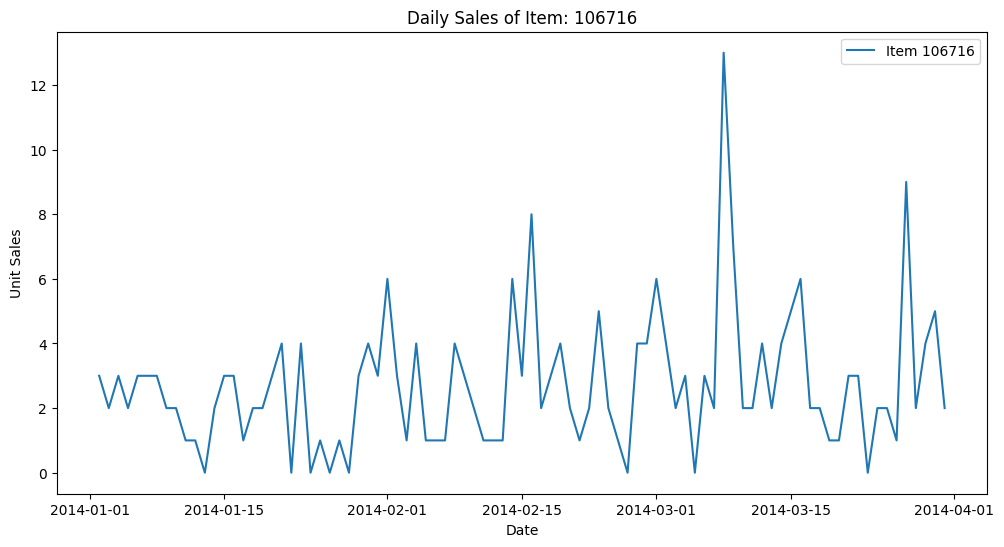

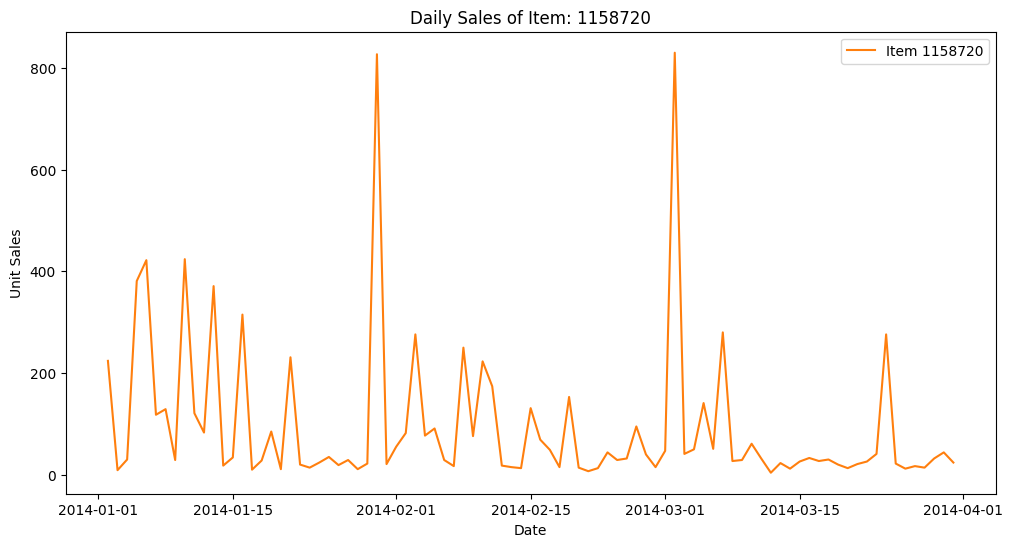

In [41]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Create a copy of the dataframe
df_copy = df.copy()

# Generate a colormap using the recommended method
colormap = plt.colormaps.get_cmap("tab10")  # No need for extra argument

# Iterate through unique item_nbr values
for idx, item_nbr in enumerate(df_copy['item_nbr'].unique()):
    df_item = df_copy[df_copy['item_nbr'] == item_nbr].copy()

    # Group by date and sum unit_sales
    df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()

    # Set 'date' as the index
    df_item.set_index('date', inplace=True)

    # Fill missing dates with zero sales
    df_item = df_item.asfreq('D').fillna(0)

    # Create a plot with a different color for each item
    plt.figure(figsize=(12, 6))
    plt.plot(df_item.index, df_item['unit_sales'], color=colormap(idx % 10), label=f'Item {item_nbr}')

    plt.title(f'Daily Sales of Item: {item_nbr}')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.show()


# Step 3. Preprocessing the Data for Prophet

In [42]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_copy['unit_sales'] = scaler.fit_transform(df_copy[['unit_sales']])

# Initialize dictionaries for different items
X_items = {}
y_items = {}
X_train_items = {}
X_test_items = {}
y_train_items = {}
y_test_items = {}

unique_items = df_copy['item_nbr'].unique()

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Set sequence length (e.g., past 30 days of sales)
seq_length = 30

# Process each item separately
for item in unique_items:
    item_data = df_copy[df_copy['item_nbr'] == item]

    # Get sequences
    data = item_data['unit_sales'].values
    X, y = create_sequences(data, seq_length)

    # Split into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Store in dictionaries
    X_items[item] = X
    y_items[item] = y
    X_train_items[item] = X_train
    X_test_items[item] = X_test
    y_train_items[item] = y_train
    y_test_items[item] = y_test


# Step 4. Multiplicative Prophet model

In [43]:
!pip install prophet


In [55]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Dictionary to store Prophet models and forecasts for each item
prophet_models = {}
forecasts = {}

# List of external regressors (modify based on your dataset)
external_regressors = ['promo', 'holiday', 'day_of_week', 'rolling_avg_7', 'rolling_avg_30']

# Loop through each unique item and train a separate Prophet model
for item in unique_items:
    print(f"Training Prophet model for item: {item}")

    # Filter data for the specific item
    item_data = df_copy[df_copy['item_nbr'] == item].copy()

    # Rename columns for Prophet format
    item_data = item_data.rename(columns={'date': 'ds', 'unit_sales': 'y'})

    # Create a Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )

    # Add external regressors
    for reg in external_regressors:
        if reg in item_data.columns:
            model.add_regressor(reg)

    # Fit the model
    model.fit(item_data)

    # Make future predictions for the next 3 days
    future = model.make_future_dataframe(periods=3)

    # Add external regressors to future dataframe
    for reg in external_regressors:
        if reg in item_data.columns:
            future[reg] = item_data[reg].iloc[-30:].values  # Use last known values

    # Generate forecast
    forecast = model.predict(future)

    # Store the trained model and forecast
    prophet_models[item] = model
    forecasts[item] = forecast

    print(f"Forecasting completed for item: {item}")

# Now we have trained Prophet models for each item.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3kokryo1/eca3kx9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3kokryo1/o875s2r2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90610', 'data', 'file=/tmp/tmp3kokryo1/eca3kx9h.json', 'init=/tmp/tmp3kokryo1/o875s2r2.json', 'output', 'file=/tmp/tmp3kokryo1/prophet_model1xhvcl89/prophet_model-20250306230314.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:03:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet model for item: 106716


23:03:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3kokryo1/6rxzl_p7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3kokryo1/eza91y32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9218', 'data', 'file=/tmp/tmp3kokryo1/6rxzl_p7.json', 'init=/tmp/tmp3kokryo1/eza91y32.json', 'output', 'file=/tmp/tmp3kokryo1/prophet_model0v4xh266/prophet_model-20250306230314.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:03:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Forecasting completed for item: 106716
Training Prophet model for item: 1158720


23:03:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecasting completed for item: 1158720


In [56]:
forecasts[1158720].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-01-02,-0.234341,-0.070963,0.345943,-0.234341,-0.234341,-1.594392,-1.594392,-1.594392,-0.060480,-0.060480,-0.060480,-1.533912,-1.533912,-1.533912,0.0,0.0,0.0,0.139290
1,2014-01-03,-0.222026,-0.037689,0.405800,-0.222026,-0.222026,-1.820853,-1.820853,-1.820853,-0.038305,-0.038305,-0.038305,-1.782548,-1.782548,-1.782548,0.0,0.0,0.0,0.182251
2,2014-01-04,-0.209711,0.019889,0.427307,-0.209711,-0.209711,-2.036096,-2.036096,-2.036096,-0.014352,-0.014352,-0.014352,-2.021743,-2.021743,-2.021743,0.0,0.0,0.0,0.217281
3,2014-01-05,-0.197396,0.008699,0.430764,-0.197396,-0.197396,-2.109755,-2.109755,-2.109755,0.133693,0.133693,0.133693,-2.243448,-2.243448,-2.243448,0.0,0.0,0.0,0.219061
4,2014-01-06,-0.185081,0.057736,0.464212,-0.185081,-0.185081,-2.377690,-2.377690,-2.377690,0.062739,0.062739,0.062739,-2.440429,-2.440429,-2.440429,0.0,0.0,0.0,0.254984


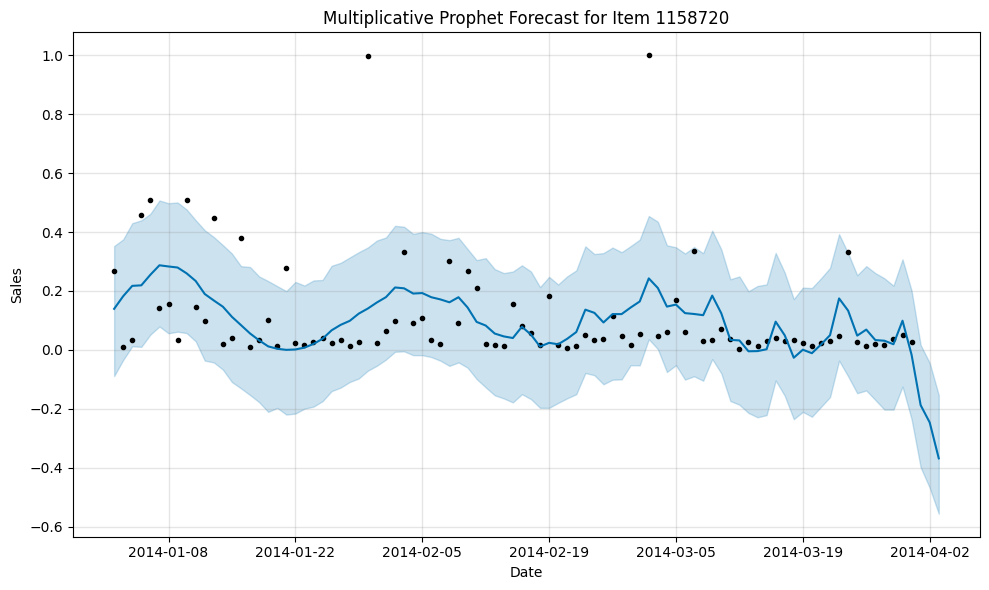

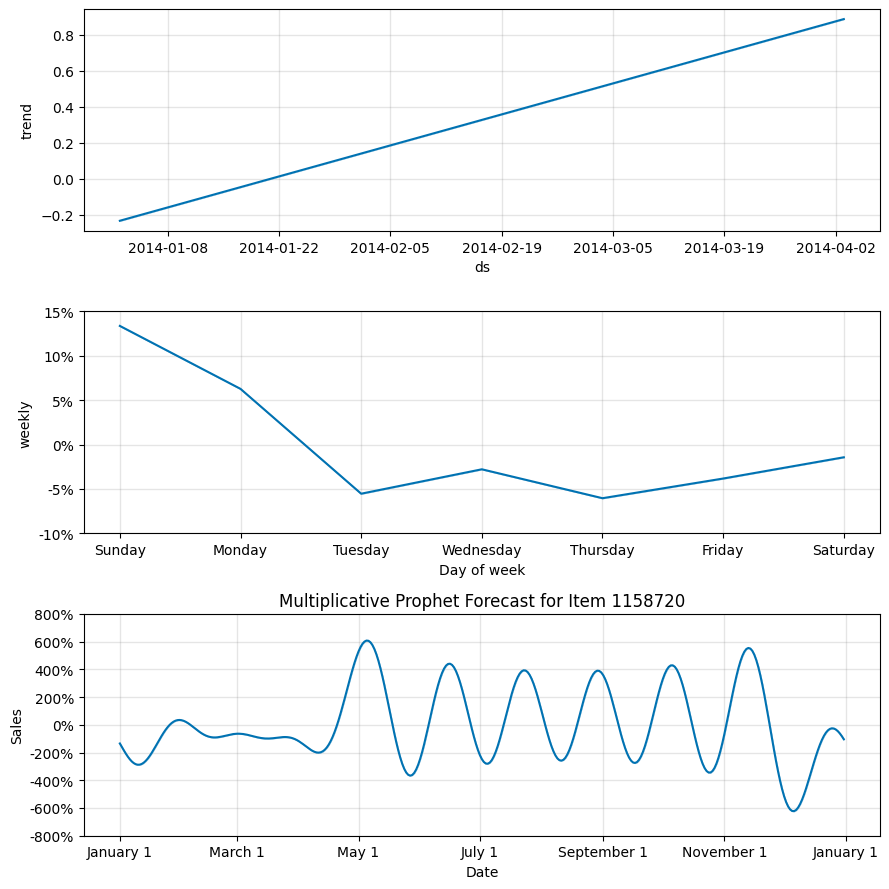

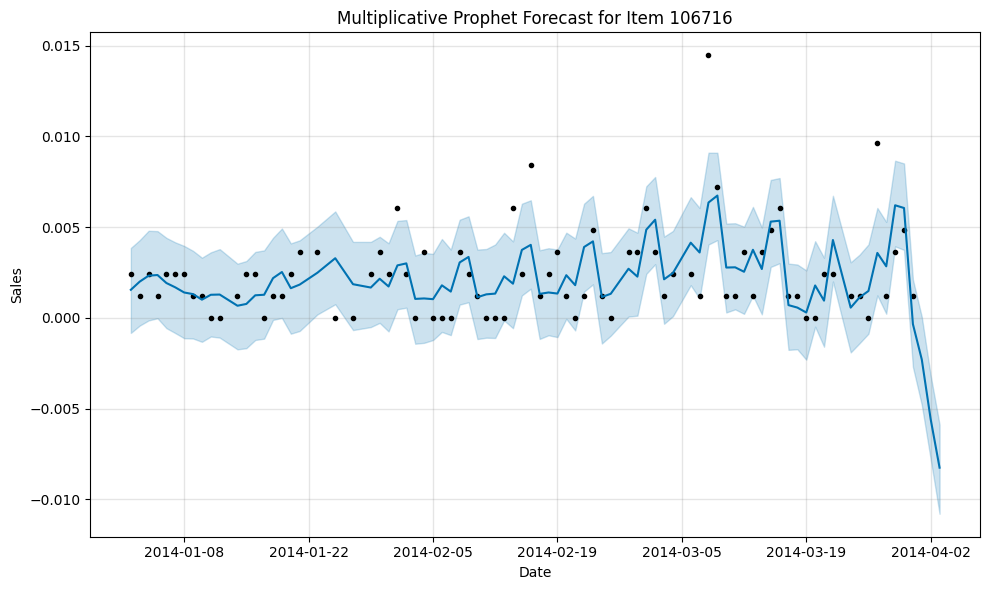

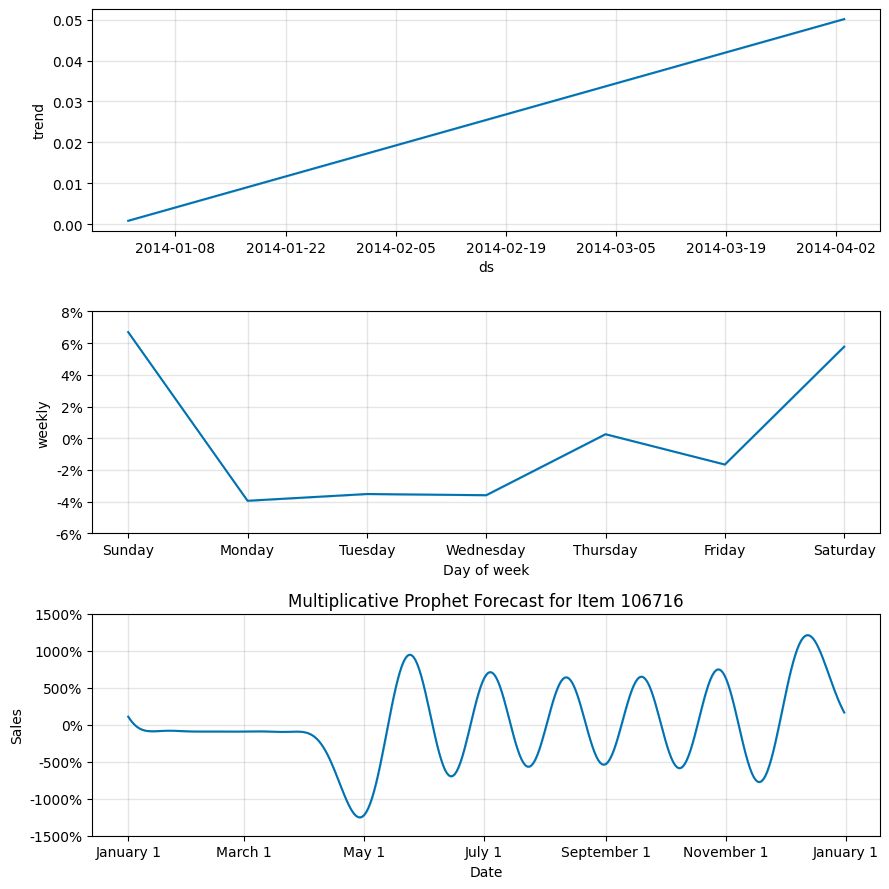

In [57]:
#future = model.make_future_dataframe(periods = 3,freq='D')

future_1158720 = prophet_models[1158720].make_future_dataframe(periods=3, freq='D')

future_1158720.tail()

forecast_1158720 = prophet_models[1158720].predict(future_1158720)

forecast_1158720[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = prophet_models[1158720].plot(forecast_1158720)
plt.title('Multiplicative Prophet Forecast for Item 1158720')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()

fig2 = prophet_models[1158720].plot_components(forecast_1158720)
plt.title('Multiplicative Prophet Forecast for Item 1158720')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()

future_106716= prophet_models[106716].make_future_dataframe(periods=3, freq='D')

future_106716.tail()

forecast_106716 = prophet_models[106716].predict(future_106716)

forecast_106716[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = prophet_models[106716].plot(forecast_106716)
plt.title('Multiplicative Prophet Forecast for Item 106716')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()

fig2 = prophet_models[106716].plot_components(forecast_106716)
plt.title('Multiplicative Prophet Forecast for Item 106716')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()



#Step 5. Additive Prophet Model

In [58]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Dictionary to store Prophet models and forecasts for each item
prophet_models = {}
forecasts = {}

# List of external regressors (modify based on your dataset)
external_regressors = ['promo', 'holiday', 'day_of_week', 'rolling_avg_7', 'rolling_avg_30']

# Loop through each unique item and train a separate Prophet model
for item in unique_items:
    print(f"Training Prophet model for item: {item}")

    # Filter data for the specific item
    item_data = df_copy[df_copy['item_nbr'] == item].copy()

    # Rename columns for Prophet format
    item_data = item_data.rename(columns={'date': 'ds', 'unit_sales': 'y'})

    # Create a Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive'
    )

    # Add external regressors
    for reg in external_regressors:
        if reg in item_data.columns:
            model.add_regressor(reg)

    # Fit the model
    model.fit(item_data)

    # Make future predictions for the next 3 days
    future = model.make_future_dataframe(periods=3)

    # Add external regressors to future dataframe
    for reg in external_regressors:
        if reg in item_data.columns:
            future[reg] = item_data[reg].iloc[-30:].values  # Use last known values

    # Generate forecast
    forecast = model.predict(future)

    # Store the trained model and forecast
    prophet_models[item] = model
    forecasts[item] = forecast

    print(f"Forecasting completed for item: {item}")

# Now we have trained Prophet models for each item.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3kokryo1/uonf_2eh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3kokryo1/16u_c3p4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47545', 'data', 'file=/tmp/tmp3kokryo1/uonf_2eh.json', 'init=/tmp/tmp3kokryo1/16u_c3p4.json', 'output', 'file=/tmp/tmp3kokryo1/prophet_model3qvze36y/prophet_model-20250306230329.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:03:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet model for item: 106716


23:03:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3kokryo1/c1p4evzd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3kokryo1/ct4ys59j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16504', 'data', 'file=/tmp/tmp3kokryo1/c1p4evzd.json', 'init=/tmp/tmp3kokryo1/ct4ys59j.json', 'output', 'file=/tmp/tmp3kokryo1/prophet_modeltdk44tld/prophet_model-20250306230330.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:03:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Forecasting completed for item: 106716
Training Prophet model for item: 1158720


23:03:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecasting completed for item: 1158720


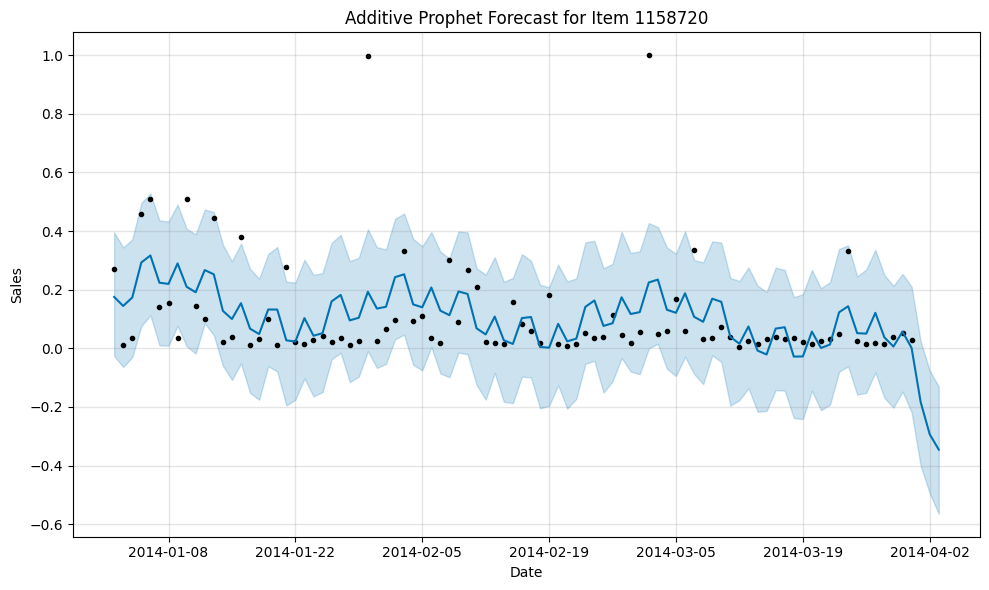

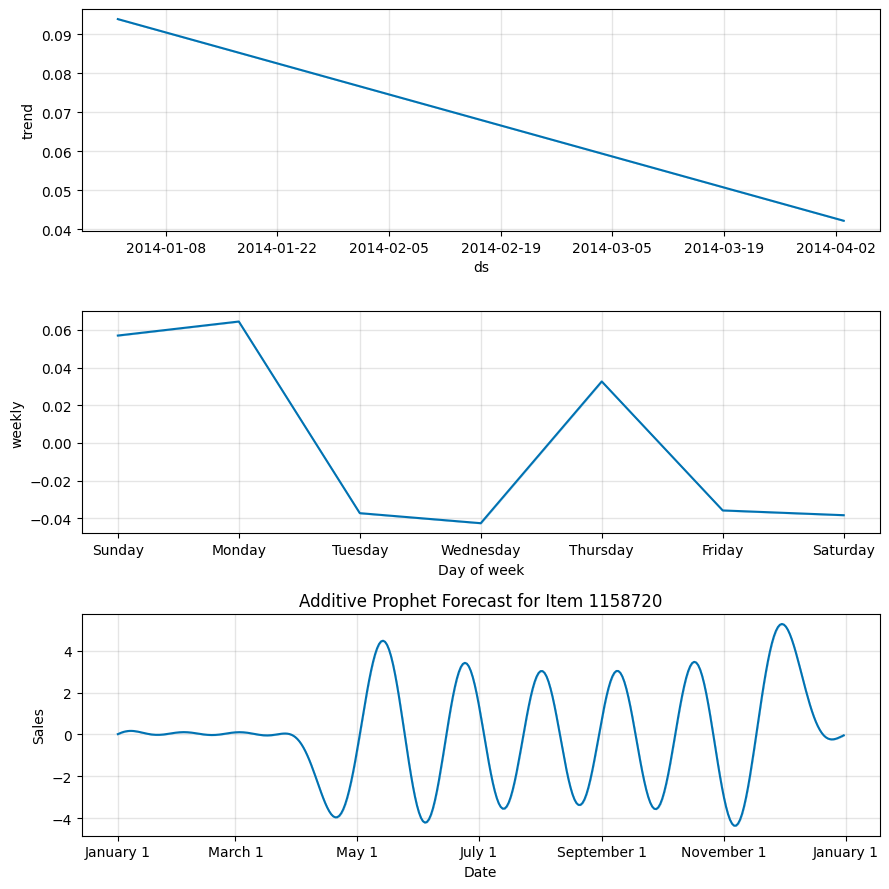

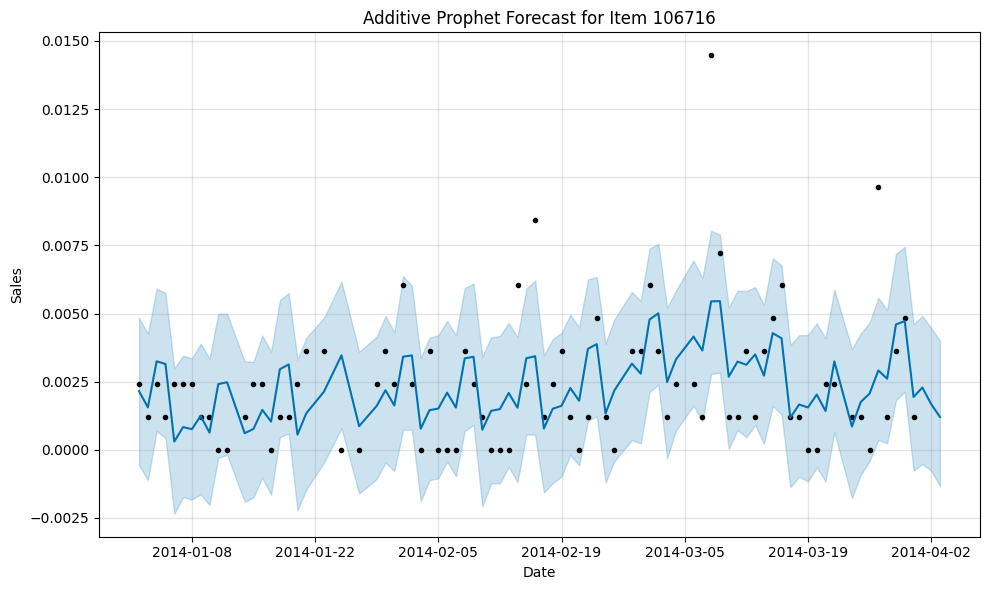

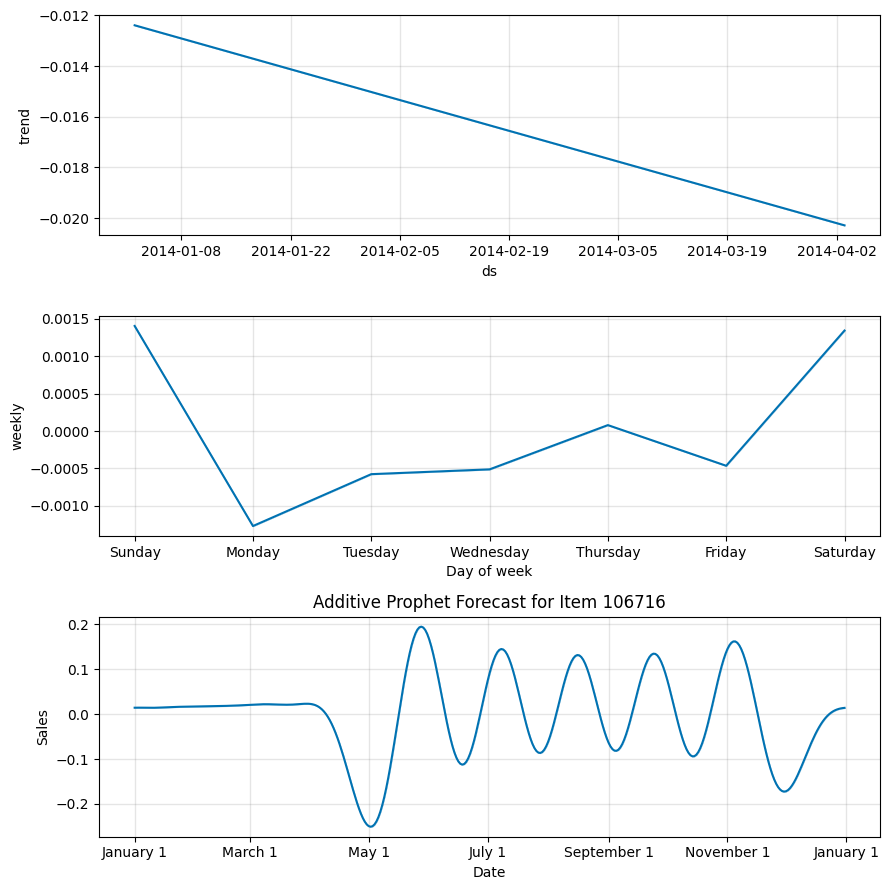

In [59]:
#future = model.make_future_dataframe(periods = 3,freq='D')

future_1158720 = prophet_models[1158720].make_future_dataframe(periods=3, freq='D')

future_1158720.tail()

forecast_1158720 = prophet_models[1158720].predict(future_1158720)

forecast_1158720[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = prophet_models[1158720].plot(forecast_1158720)

plt.title('Additive Prophet Forecast for Item 1158720')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()
fig2 = prophet_models[1158720].plot_components(forecast_1158720)

plt.title('Additive Prophet Forecast for Item 1158720')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()

future_106716= prophet_models[106716].make_future_dataframe(periods=3, freq='D')

future_106716.tail()

forecast_106716 = prophet_models[106716].predict(future_106716)

forecast_106716[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = prophet_models[106716].plot(forecast_106716)

plt.title('Additive Prophet Forecast for Item 106716')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()

fig2 = prophet_models[106716].plot_components(forecast_106716)

plt.title('Additive Prophet Forecast for Item 106716')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()



 Visualizing Prophet Forecasts

<Figure size 1400x700 with 0 Axes>

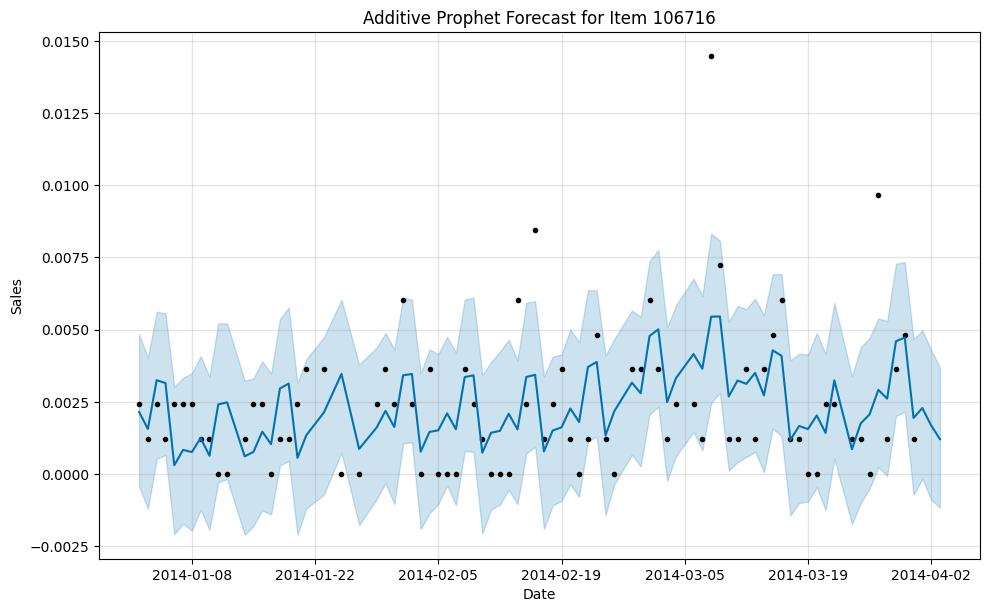

<Figure size 1400x700 with 0 Axes>

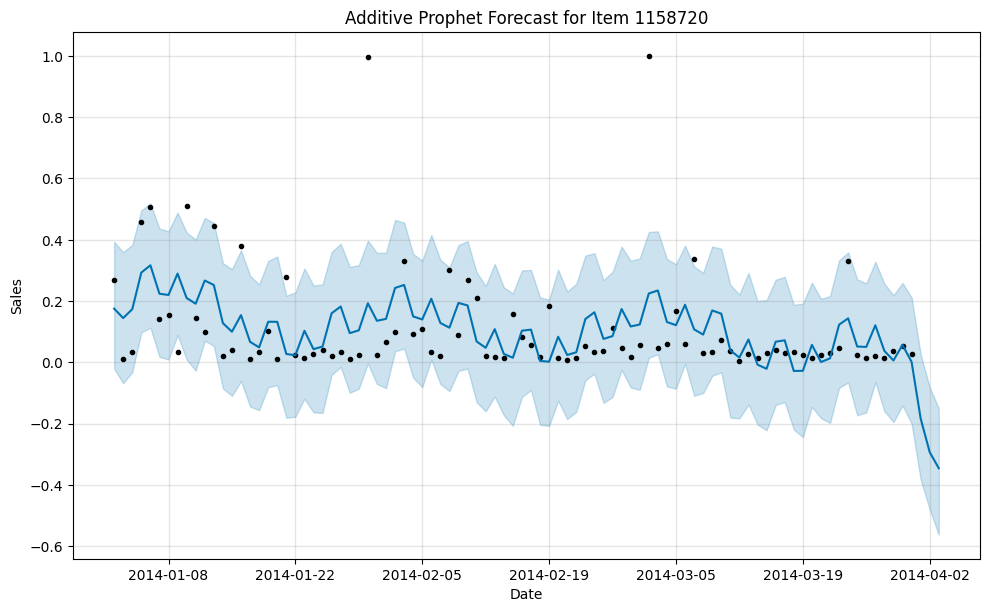

Visualization completed for all items.


In [60]:
# Function to visualize Prophet forecast
def plot_prophet_forecast(item, model, forecast):
    plt.figure(figsize=(14, 7))
    model.plot(forecast)
    plt.title(f'Additive Prophet Forecast for Item {item}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

# Loop through each item to visualize
for item in unique_items:
    plot_prophet_forecast(item, prophet_models[item], forecasts[item])

print("Visualization completed for all items.")


# Step 6. Integrating Holidays into the Prophet Model

In [61]:
#open holidays dataset
df_holidays = pd.read_csv("/content/holidays_events.csv")

In [62]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


#Step 1: Prepare the Holiday Data

Prophet expects holidays in this format:
holidays = pd.DataFrame({
    'holiday': 'event_name',
    'ds': 'YYYY-MM-DD'
})

In [63]:
# Ensure date column is in datetime format
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

# Create a properly formatted holidays DataFrame for Prophet
prophet_holidays = df_holidays[['date', 'description']].rename(columns={'date': 'ds', 'description': 'holiday'})

# Prophet requires 'holiday' column to be a string
prophet_holidays['holiday'] = prophet_holidays['holiday'].astype(str)

# Display the reformatted holiday DataFrame
print(prophet_holidays.head())


          ds                        holiday
0 2012-03-02             Fundacion de Manta
1 2012-04-01  Provincializacion de Cotopaxi
2 2012-04-12            Fundacion de Cuenca
3 2012-04-14      Cantonizacion de Libertad
4 2012-04-21      Cantonizacion de Riobamba


# Step 2: Merge Holidays with Sales Data

In [64]:
# Convert sales data date to datetime
df['date'] = pd.to_datetime(df['date'])

# Merge with holiday data to get a holiday flag
df = df.merge(prophet_holidays, left_on='date', right_on='ds', how='left')

# If a date is a holiday, set flag to 1, else 0
df['holiday_flag'] = df['holiday'].notna().astype(int)

# Drop duplicate 'ds' column
df.drop(columns=['ds'], inplace=True)

# Print to verify changes
print(df[['date', 'holiday', 'holiday_flag']].head(10))


        date holiday  holiday_flag
0 2014-01-02     NaN             0
1 2014-01-02     NaN             0
2 2014-01-03     NaN             0
3 2014-01-03     NaN             0
4 2014-01-04     NaN             0
5 2014-01-04     NaN             0
6 2014-01-05     NaN             0
7 2014-01-05     NaN             0
8 2014-01-06     NaN             0
9 2014-01-06     NaN             0


#Step 3: Train Prophet with Holidays

In [65]:
print(item_data.isnull().sum())


id                 0
ds                 0
store_nbr          0
item_nbr           0
y                  0
onpromotion        0
family             0
class              0
perishable         0
outlier_flag       0
holiday_flag       0
expanding_mean     0
lag_7              1
lag_30             3
rolling_std_7      1
lag_1              0
lag_2              0
lag_5              1
lag_10             3
lag_12            10
rolling_mean_7     1
dcoilwtico         0
dtype: int64


In [66]:
import pandas as pd
import numpy as np

# List of lag features to fill
lag_cols = ['lag_7', 'lag_30', 'rolling_std_7', 'lag_1', 'lag_2', 'lag_5', 'lag_10', 'lag_12', 'rolling_mean_7']

# Step 1: Fill missing values with the column mean (for initial NaNs)
for col in lag_cols:
    df[col] = df[col].fillna(df[col].mean())

# Step 2: Fill remaining NaNs with rolling mean (7-day window)
for col in lag_cols:
    df[col] = df[col].fillna(df[col].rolling(window=7, min_periods=1).mean())

# Step 3: Interpolate remaining missing values (linear method)
df[lag_cols] = df[lag_cols].interpolate(method='linear')
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


# Step 4: Final check to ensure no NaNs remain
print(df.isnull().sum())  # Should show 0 missing values





id                  0
date                0
store_nbr           0
item_nbr            0
unit_sales          0
onpromotion         0
family              0
class               0
perishable          0
outlier_flag        0
holiday_flag        0
expanding_mean      0
lag_7               0
lag_30              0
rolling_std_7       0
lag_1               0
lag_2               0
lag_5               0
lag_10              0
lag_12              0
rolling_mean_7      0
dcoilwtico          0
holiday           164
dtype: int64


<ipython-input-66-9bd4abcd5675>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


In [68]:
import pickle
from prophet import Prophet
import pandas as pd

# Define hyperparameters for each item
prophet_params = {
    106716: {  # Parameters for item 106716
        "changepoint_prior_scale": 0.015,
        "seasonality_prior_scale": 6,
        "holidays_prior_scale": 12,
        "fourier_order": 5
    },
    1158720: {  # Parameters for item 1158720
        "changepoint_prior_scale": 0.2,
        "seasonality_prior_scale": 20,
        "holidays_prior_scale": 25,
        "fourier_order": 20
    }
}

# List of external regressors
external_regressors = ['onpromotion', 'expanding_mean', 'lag_7', 'lag_30',
                       'rolling_std_7', 'rolling_mean_7', 'dcoilwtico', 'holiday_flag']

# Dictionaries to store Prophet models and forecasts
prophet_models = {}
forecasts = {}

# Rename holidays column for Prophet
holidays = prophet_holidays.rename(columns={'ds': 'date'})

# Loop through each item and train a separate Prophet model
for item in unique_items:
    print(f"Training Prophet model for item: {item}")

    # Filter data for the specific item
    item_data = df[df['item_nbr'] == item].copy()

    # Rename columns for Prophet
    item_data = item_data.rename(columns={'date': 'ds', 'unit_sales': 'y'})

    # Retrieve hyperparameters for the current item, or use default values
    params = prophet_params.get(item, {
        "changepoint_prior_scale": 0.05,  # Default value
        "seasonality_prior_scale": 10,
        "holidays_prior_scale": 15,
        "fourier_order": 6
    })

    # Create a Prophet model with item-specific hyperparameters
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive',
        holidays=prophet_holidays,
        changepoint_prior_scale=params["changepoint_prior_scale"],
        seasonality_prior_scale=params["seasonality_prior_scale"],
        holidays_prior_scale=params["holidays_prior_scale"]
    )

    # Add custom seasonality with item-specific Fourier order
    model.add_seasonality(name='monthly', period=3, fourier_order=params["fourier_order"])

    # Add external regressors
    for reg in external_regressors:
        if reg in item_data.columns:
            model.add_regressor(reg)

    # Fit the model
    model.fit(item_data)

    # Make future predictions for the next 3 days
    future = model.make_future_dataframe(periods=3)

    # Merge external regressors from item_data into future
    future = future.merge(item_data[['ds'] + external_regressors], on='ds', how='left')

    # Fill missing values in future with the last known value
    for reg in external_regressors:
        if reg in future.columns:
            future[reg].fillna(item_data[reg].iloc[-1], inplace=True)

    # Generate forecast
    forecast = model.predict(future)

    # Save the trained model
    with open(f"prophet_model_stor_{item}.pkl", "wb") as f:
        pickle.dump(model, f)

    # Save the forecast to a CSV file
    forecast.to_csv(f"forecast_{item}.csv", index=False)

    # Store the trained model and forecast in dictionaries
    prophet_models[item] = model
    forecasts[item] = forecast

    print(f"Forecasting completed and model saved for item: {item}")

print("✅ All models trained and saved successfully!")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3kokryo1/pap1wjjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3kokryo1/odo8tv3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59680', 'data', 'file=/tmp/tmp3kokryo1/pap1wjjb.json', 'init=/tmp/tmp3kokryo1/odo8tv3a.json', 'output', 'file=/tmp/tmp3kokryo1/prophet_model76_9t5wp/prophet_model-20250306230531.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:05:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet model for item: 106716


23:05:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-68-63a0b973f0e2>:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future[reg].fillna(item_data[reg].iloc[-1], inplace=True)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3kokryo1/cutw1iam.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3kokryo1/crztsb3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/proph

Forecasting completed and model saved for item: 106716
Training Prophet model for item: 1158720


23:05:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-68-63a0b973f0e2>:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future[reg].fillna(item_data[reg].iloc[-1], inplace=True)


Forecasting completed and model saved for item: 1158720
✅ All models trained and saved successfully!


#Step 4: Visualize Prophet Forecast with Holidays

<Figure size 1400x700 with 0 Axes>

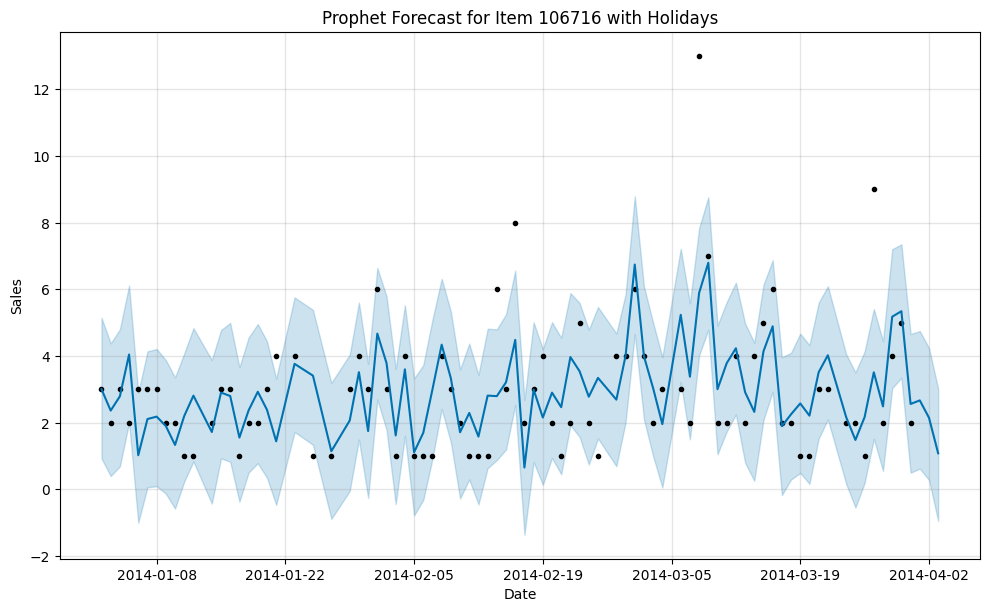

<Figure size 1400x700 with 0 Axes>

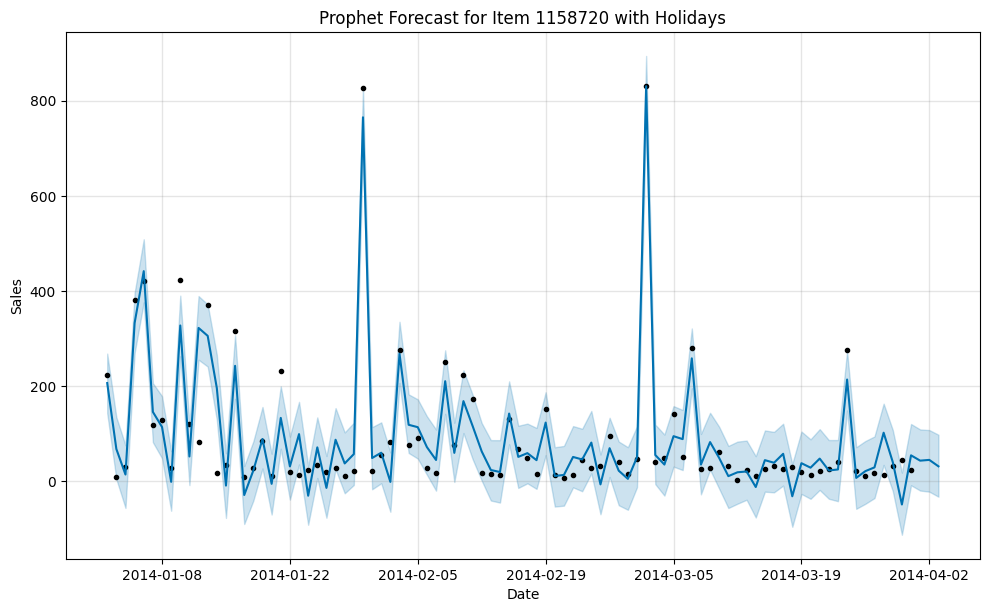

Visualization completed for all items.


In [69]:
import matplotlib.pyplot as plt

# Function to visualize Prophet forecast
def plot_prophet_forecast(item, model, forecast):
    plt.figure(figsize=(14, 7))
    model.plot(forecast)
    plt.title(f'Prophet Forecast for Item {item} with Holidays')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

# Loop through each item to visualize
for item in unique_items:
    plot_prophet_forecast(item, prophet_models[item], forecasts[item])

print("Visualization completed for all items.")


In [70]:
#evaluate the model mse, rmse, mae
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse_values = []
for item in unique_items:
  # Filter the forecast to the date range present in the original DataFrame
  # Use 'date' instead of 'ds' as the column name for the original DataFrame
  filtered_forecast = forecasts[item][forecasts[item]['ds'].isin(df[df['item_nbr'] == item]['date'])]

  mse = mean_squared_error(df[df['item_nbr'] == item]['unit_sales'], filtered_forecast['yhat'])
  mse_values.append(mse)

  print(f"Item {item} MSE: {mse}")
  print(f"Item {item} RMSE: {sqrt(mse)}")
  print(f"Item {item} MAE: {mean_absolute_error(df[df['item_nbr'] == item]['unit_sales'], filtered_forecast['yhat'])}")

Item 106716 MSE: 2.4536653711861005
Item 106716 RMSE: 1.5664180065314943
Item 106716 MAE: 1.0869313648634031
Item 1158720 MSE: 2532.4792264173843
Item 1158720 RMSE: 50.32374416135374
Item 1158720 MAE: 35.160669002566195


#Conclusions

### **📊 Final Model Comparison: XGBoost vs. SARIMAX vs. ARIMA/SARIMA vs. Prophet**

With the **Prophet model results** now available, we can analyze how it compares to the **other forecasting models (SARIMAX, ARIMA, SARIMA, and XGBoost)**.

---

## **🔹 Model Performance Comparison Table**
| **Model**              | **Item 106716 - MAE** | **Item 106716 - RMSE** | **Item 1158720 - MAE** | **Item 1158720 - RMSE** |
|------------------------|----------------------|----------------------|----------------------|----------------------|
| **ARIMA(1,0,0)**       | 1.63                 | 2.17                 | 90.49                | 92.82                |
| **SARIMA(2,1,1)(1,1,1,7)** | 2.16                 | 2.96                 | 37.89                | 69.73                |
| **SARIMAX(1,0,0)(0,0,0,7) with basic exogenous** | 1.72                 | 2.33                 | 43.47                | 53.78                |
| **SARIMAX(1,0,0)(0,0,0,7) with all exogenous** | 1.63                 | 2.38                 | 34.62                | **43.10** ✅ |
| **XGBoost**            | 3.18                 | 3.53                 | **28.96** ✅          | 43.20                |
| **Prophet**            | **1.09** ✅           | **1.57** ✅           | 35.16                | 50.32                |

---

### **🔹 Key Observations**
#### **Item 106716**
1. **Prophet is the best model overall**, with the lowest MAE (**1.09**) and RMSE (**1.57**).
2. **ARIMA (1.63 MAE, 2.17 RMSE) and SARIMAX (1.63 MAE, 2.38 RMSE) perform well**, but Prophet achieves better accuracy.
3. **XGBoost performs the worst**, with much higher errors (**3.18 MAE, 3.53 RMSE**).

#### **Item 1158720**
1. **XGBoost achieves the lowest MAE (28.96)**, making it the best model if absolute error matters.
2. **SARIMAX (34.62 MAE, 43.10 RMSE) is the best overall time-series model**, outperforming Prophet.
3. **Prophet’s RMSE (50.32) is worse than SARIMAX (43.10) and XGBoost (43.20), making it less ideal for Item 1158720.**
4. **SARIMA and ARIMA struggle to match the accuracy of Prophet, SARIMAX, or XGBoost.**

---

## **📌 Final Conclusion**
### **For Item 106716:**
- **Best Model:** **Prophet** (lowest RMSE & MAE).
- **Alternative Model:** **ARIMA(1,0,0) or SARIMAX(1,0,0) with all exogenous variables** (decent performance).
- **Worst Model:** **XGBoost** (high RMSE and MAE, poor fit for this dataset).

### **For Item 1158720:**
- **Best Model:** **XGBoost (lowest MAE, competitive RMSE).**
- **Best Time-Series Model:** **SARIMAX(1,0,0) with all exogenous variables** (best RMSE among time-series models).
- **Prophet is slightly worse than SARIMAX and XGBoost for this dataset** (higher RMSE).

---

## **🚀 Final Recommendation**
1. **For Item 106716, Prophet is the most accurate model and should be used.**
2. **For Item 1158720, SARIMAX and XGBoost are both strong choices.**  
   - **If MAE is the priority**, **XGBoost** is best.  
   - **If a time-series model is required**, **SARIMAX** is better.  
3. **Hybrid approaches** (combining Prophet/XGBoost + SARIMAX residuals) could further enhance forecasts.

Overall, **Prophet dominates for Item 106716**, while **XGBoost and SARIMAX lead for Item 1158720**. 🚀🔥  

Let me know if you need further refinements!